## Bloom lab “Rachel-style 2019” flu neutralization assays

### Experimental setup

Here we describe how to parse data from influenza neutralization assays
set up in the **very specific** way used by Rachel Eguia and Juhye Lee
in the [Bloom lab](https://research.fhcrc.org/bloom/en.html) as of
2019. If you want to parse data using this approach, you must set up the
assays exactly as described here.

For general background on the Bloom lab GFP influenza neutralization
assays, see:

* The [Hooper et al
  (2013)](https://jvi.asm.org/content/87/23/12531.full) paper that
  originally described these assays.

* The [Doud et al
  (2017)](https://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1006271)
  paper that gives a more detailed protocol.

* The extensive experimental details at
  [https://github.com/jbloomlab/flu_PB1flank-GFP_neut_assay](https://github.com/jbloomlab/flu_PB1flank-GFP_neut_assay)

Here we describe how to parse data from the Excel files created by the
Tecan Safire Infinite M1000 used by the [Bloom
lab](https://research.fhcrc.org/bloom/en.html) to read these assays.

The assays are assumed to be in 96-well plates, with a different sample
type in each of the 8 rows (A to H) and the serum diluted across the 12
columns (1 to 12). The highest serum concentration is in column 12 and
it is serially diluted down to the lowest concentration in column 1. The
samples are as follows:

> * there are three replicates of the same virus
>   and serum in rows D, E, and F

> * rows C and G have the no-serum control
>   used to establish the maximal signal in the absence of neutralization -
>   row B has the virus-only control used to establish the background signal
>   expected at full neutralization

> * rows A and G have a media-only control
>   that should have very low signal (these rows can also be empty)

See
`example_data/rachelstyle2019_22Feb19_setup.pdf`
for Rachel’s lab notes on how exactly she set up the assays analyzed
here.

### Import Python packages

First, import the necessary Python modules. In addition to the
`neutcurve` package itself, we also use
[pandas](https://pandas.pydata.org) to hold the data and
[pyyaml](https://pyyaml.org/wiki/PyYAMLDocumentation) to parse the
YAML configuration file:

In [1]:
import os

import pandas as pd

import yaml

import neutcurve
import neutcurve.parse_excel

Set output format of pandas Data Frames:

In [2]:
pd.set_option('display.float_format', '{:.3g}'.format)

# Specify configuration of data

In order to parse the raw experimental data in the Excel files, we need
to describe how they are configured. The data can consist of one or more
Excel files, each of which may have one or more sheets. Each sheet
specifies three replicates of a virus against a serum as described
above.

In order to parse an Excel file, we need to supply the information taken
by `neutcurve.parse_excel.parseRachelStyle2019()`. As described in
the docs for that function, for each Excel file we need:

* *excelfile*: the name of the Excel file

* *sheet_mapping*: a dictionary keyed be the name of each sheet in
  *excelfile* which in turn specifies:

  * *serum*: name of serum

  * *virus*: name of virus

  * *initial_concentration*: highest concentration of serum

  * *dilution_factor*: dilution factor in serial dilutions of serum

  * *excluded_dilutions* (optional): list of dilutions to exclude, with
    1 being the least dilute and 12 being the most dilute. Useful if some
    columns in the plate have a known problem (for instance, edge effects).

You can specify this information in a [YAML
format](https://docs.ansible.com/ansible/latest/reference_appendices/YAMLSyntax.html)
file. In this notebook, we parse the Excel data in the single Excel file
`example_data/rachelstyle2019_22Feb19_neutdata.xlsx`,
which consists of eight sheets. So we have created a YAML file,
`example_data/rachelstyle2019_config.yaml`
that specifies the information in that Excel file:

In [3]:
config_file = 'example_data/rachelstyle2019_config.yaml'

<!-- Next cell sets right file path if running with pytest from top directory. -->
Here are the contents of the YAML configuration file.

In [4]:
with open(config_file) as f:
    print(f.read().strip())

- 22Feb19:
    excelfile: example_data/rachelstyle2019_22Feb19_neutdata.xlsx
    sheet_mapping:
      16:
        serum: HC080048
        virus: wt
        dilution_factor: 3
        initial_concentration: 0.00926
      17:
        serum: HC080043
        virus: wt
        dilution_factor: 3
        initial_concentration: 0.00926
      18:
        serum: HC060106
        virus: wt
        dilution_factor: 3
        initial_concentration: 0.00926
        excluded_dilutions: [5, 6]
      19:
        serum: HC140010
        virus: wt
        dilution_factor: 3
        initial_concentration: 0.00926
      20:
        serum: HC070072
        virus: wt
        dilution_factor: 3
        initial_concentration: 0.00926
      21:
        serum: HC070041
        virus: wt
        dilution_factor: 3
        initial_concentration: 0.00926
      22:
        serum: HC120043
        virus: wt
        dilution_factor: 3
        initial_concentration: 0.00926
      23:
        serum: HC150036
        v

Note how the YAML file lists the experiment for each Excel file (in this
case, there is only one), and then gives the name of the Excel file
(*excelfile*) and the specificiation for the sheets in that file
(*sheet_mapping*). Therefore, the dictionary for each experiment can be
directly passed to `neutcurve.parse_excel.parseRachelStyle2019()`
as .

Note how to illustrate the *excluded_dilutions* option, we have excluded
two columns from serum *HC060106*. In the plots below, you can see how
the data points for those columns will be missing.

We also need to specify the output directory where the results are
written:

In [5]:
outdir = '_example_analysis/rachelstyle2019/'
os.makedirs(outdir, exist_ok=True)

# Read the data from the Excel files

Now we read in the configuration specified in our *config_file* into the
variable *config*, which will be a list of dicts:

In [6]:
with open(config_file) as f:
    config = yaml.safe_load(f)

<!-- Next cell sets right excelfile path if running with pytest from top directory. -->
Next, for each dict in *config*, we use
`neutcurve.parse_excel.parseRachelStyle2019()` to create a tidy
data frame appropriate for passing to
`neutcurve.curvefits.CurveFits` as described in Fitting curves to real data.
We then concatenate all the
tidy data frame to get our neutralization data:

In [7]:
neutdata = []  # store all data frame, then concatenate at end

for sampledict in config:
    assert len(sampledict) == 1
    sampleset, kwargs = list(sampledict.items())[0]
    print(f"Parsing data for {sampleset}...")
    neutdata.append(neutcurve.parse_excel.parseRachelStyle2019(**kwargs))

neutdata = pd.concat(neutdata)
print(f"Read data for {len(neutdata.groupby('serum'))} sera and "
      f"{len(neutdata.groupby(['serum', 'virus']))} serum / virus pairs.")

Parsing data for 22Feb19...


Read data for 8 sera and 8 serum / virus pairs.


We write the neutralization data to a CSV file in our output directory:

In [8]:
neutdatafile = os.path.join(outdir, 'neutdata.csv')
neutdata.to_csv(neutdatafile, index=False)
print(f"Wrote neutralization data to {neutdatafile}")

Wrote neutralization data to _example_analysis/rachelstyle2019/neutdata.csv


# Fit and analyze the curves

Now we can simply fit the data in *neutdata* with a
`neutcurve.curvefits.CurveFits` as in Fitting curves to real data:

In [9]:
fits = neutcurve.CurveFits(neutdata)

Make plots that show the curves for all replicates for each serum /
virus combination:

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a mas

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a mas

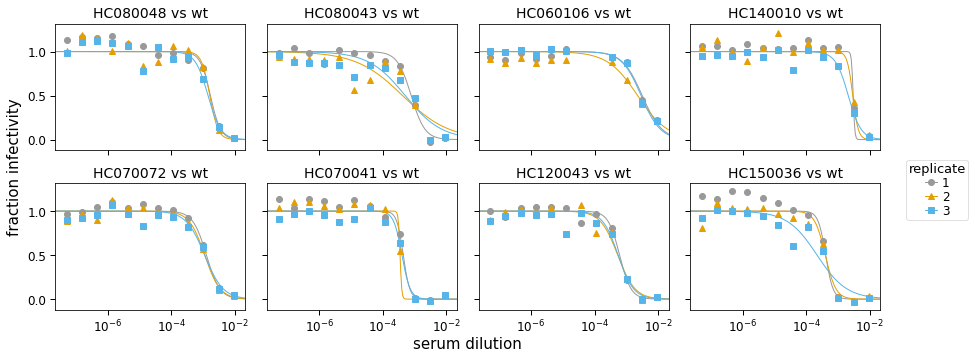

In [10]:
fig_reps, _ = fits.plotReplicates(legendtitle='replicate',
                                  xlabel='serum dilution')

Make plots that just show the across-replicate averages for each serum /
virus combination:

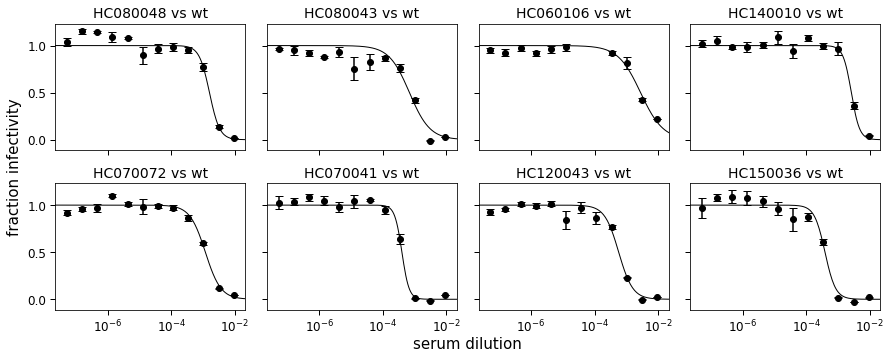

In [11]:
fig_avgs, _ = fits.plotAverages(xlabel='serum dilution')

Make plots that show all viruses for each serum. Note that for this
particular dataset, this plot isn’t really any different than the one
above–but we make it here because it will be different for datasets that
involve multiple different viruses:

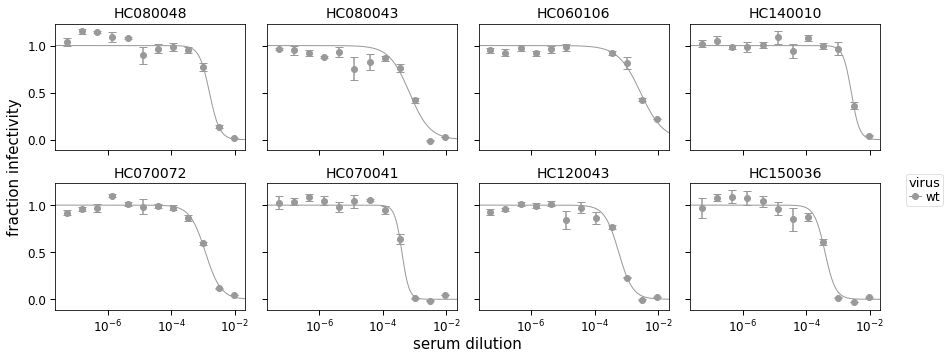

In [12]:
fig_sera, _ = fits.plotSera(legendtitle='virus',
                            xlabel='serum dilution')

Now we write all of the plots to PDF files:

In [13]:
for plotname, fig in [('replicates_plot', fig_reps),
                      ('average_plot', fig_avgs),
                      ('sera_plot', fig_sera)]:
    plotfile = os.path.join(outdir, plotname + '.pdf')
    print(f"Creating plot {plotfile}")
    fig.savefig(plotfile)

Creating plot _example_analysis/rachelstyle2019/replicates_plot.pdf


Creating plot _example_analysis/rachelstyle2019/average_plot.pdf


Creating plot _example_analysis/rachelstyle2019/sera_plot.pdf


We also look at the numerical values of the fit parameters, including
the IC50s:

In [14]:
fits.fitParams()

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,midpoint,slope,top,bottom
0,HC080048,wt,average,3,0.0016,interpolated,0.0016,0.0016,2.71,1,0
1,HC080043,wt,average,3,0.000684,interpolated,0.000684,0.000684,1.35,1,0
2,HC060106,wt,average,3,0.0028,interpolated,0.0028,0.0028,1.23,1,0
3,HC140010,wt,average,3,0.00262,interpolated,0.00262,0.00262,3.36,1,0
4,HC070072,wt,average,3,0.00118,interpolated,0.00118,0.00118,1.79,1,0
5,HC070041,wt,average,3,0.000396,interpolated,0.000396,0.000396,3.86,1,0
6,HC120043,wt,average,3,0.000573,interpolated,0.000573,0.000573,1.97,1,0
7,HC150036,wt,average,3,0.000388,interpolated,0.000388,0.000388,2.61,1,0


We write these fit parameters to a CSV file:

In [15]:
fitfile = os.path.join(outdir, 'fitparams.csv')
fits.fitParams().to_csv(fitfile, index=False)
print(f"Wrote fit parameters to {fitfile}")

Wrote fit parameters to _example_analysis/rachelstyle2019/fitparams.csv


So overall, this analysis has created several plots and CSV files in
*outdir*:

In [16]:
print(f"Here are the created files in {outdir}:\n  " +
      '\n  '.join(sorted(os.listdir(outdir))))

Here are the created files in _example_analysis/rachelstyle2019/:
  average_plot.pdf
  fitparams.csv
  neutdata.csv
  replicates_plot.pdf
  sera_plot.pdf


# Processing your own data

This document processes some example data.
To run the same analysis in your own data, download this document as a Jupyter notebook here:

Then go to the Specify configuration of data section and update the *config_file* data to point to a YAML file configuring your actual data, and change the *outdir* variable to point to the output directory that you actually want to create.